In [1]:
import os
import torch
from torch_geometric.utils import to_networkx
from torch_geometric.datasets import KarateClub
from torch.nn import Linear
from torch_geometric.nn import GCNConv
import networkx as nx
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import numpy as np
from torch.nn import Linear
from torch_geometric.nn import GCNConv


# Loading Dataset


In [2]:
#  Load Zachary's karate club network
dataset = KarateClub()

In [3]:
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Number of features: 34
Number of classes: 4


# Basic Dataset Information
basic information about the dataset, such as the number of features, classes, nodes, edges, average node degree, and checks for isolated nodes, self-loops, and whether the graph is undirected.

In [4]:
data = dataset[0]

In [5]:
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


# Graph Visualization
- use NetworkX and Matplotlib to visualize the graph.
- the graph's nodes are colored based on their classes (the club's communities), allowing to see how nodes are connected within the community structure.

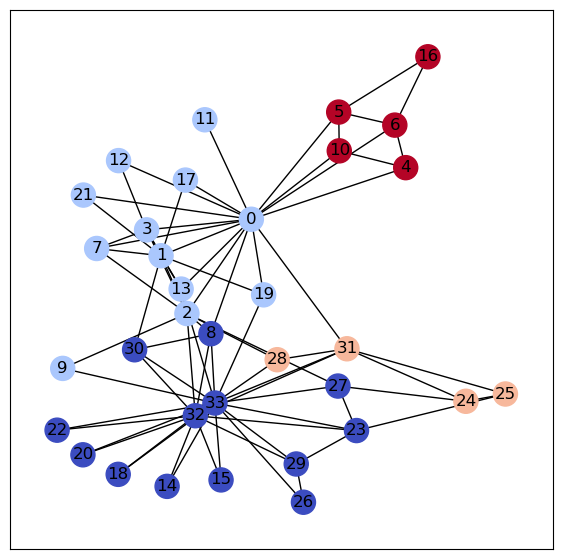

In [6]:
G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(7,7))
plt.xticks([])
plt.yticks([])
nx.draw_networkx(G,
                 pos=nx.spring_layout(G, seed=42),
                 with_labels=True,
                 node_color=data.y,
                 cmap="coolwarm")
plt.show()

In [7]:
labels = data.y

# Model Architecture (2 Layer)
- Define the GCN model architecture using PyTorch.
- The model consists of :
  - 2 GCN convolutional layers
  - a linear classifier.

In [8]:
gcn_layer = 2

In [9]:
class GCN(torch.nn.Module):
    def __init__(self, num_layers=1):
        super().__init__()

        # لایه‌های GCN را در یک لیست ذخیره می‌کنیم
        self.gcn_layers = torch.nn.ModuleList([
            GCNConv(dataset.num_features, 10) if i == 0 else GCNConv(10, 10) for i in range(num_layers)
        ])

        # لایه خروجی تمام متصل
        self.out = Linear(10, dataset.num_classes)

    def forward(self, x, edge_index):
        for gcn_layer in self.gcn_layers:
            x = gcn_layer(x, edge_index).relu()

        z = self.out(x)
        return x, z


In [10]:
model = GCN(gcn_layer)
print(model)

GCN(
  (gcn_layers): ModuleList(
    (0): GCNConv(34, 10)
    (1): GCNConv(10, 10)
  )
  (out): Linear(in_features=10, out_features=4, bias=True)
)


In [11]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)


In [12]:

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(float(loss))
    accuracies.append(float(acc))
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.37 | Acc: 35.29%
Epoch  10 | Loss: 1.16 | Acc: 35.29%
Epoch  20 | Loss: 0.87 | Acc: 85.29%
Epoch  30 | Loss: 0.40 | Acc: 88.24%
Epoch  40 | Loss: 0.11 | Acc: 100.00%
Epoch  50 | Loss: 0.04 | Acc: 100.00%
Epoch  60 | Loss: 0.01 | Acc: 100.00%
Epoch  70 | Loss: 0.01 | Acc: 100.00%
Epoch  80 | Loss: 0.00 | Acc: 100.00%
Epoch  90 | Loss: 0.00 | Acc: 100.00%
Epoch 100 | Loss: 0.00 | Acc: 100.00%
Epoch 110 | Loss: 0.00 | Acc: 100.00%
Epoch 120 | Loss: 0.00 | Acc: 100.00%
Epoch 130 | Loss: 0.00 | Acc: 100.00%
Epoch 140 | Loss: 0.00 | Acc: 100.00%
Epoch 150 | Loss: 0.00 | Acc: 100.00%
Epoch 160 | Loss: 0.00 | Acc: 100.00%
Epoch 170 | Loss: 0.00 | Acc: 100.00%
Epoch 180 | Loss: 0.00 | Acc: 100.00%
Epoch 190 | Loss: 0.00 | Acc: 100.00%
Epoch 200 | Loss: 0.00 | Acc: 100.00%


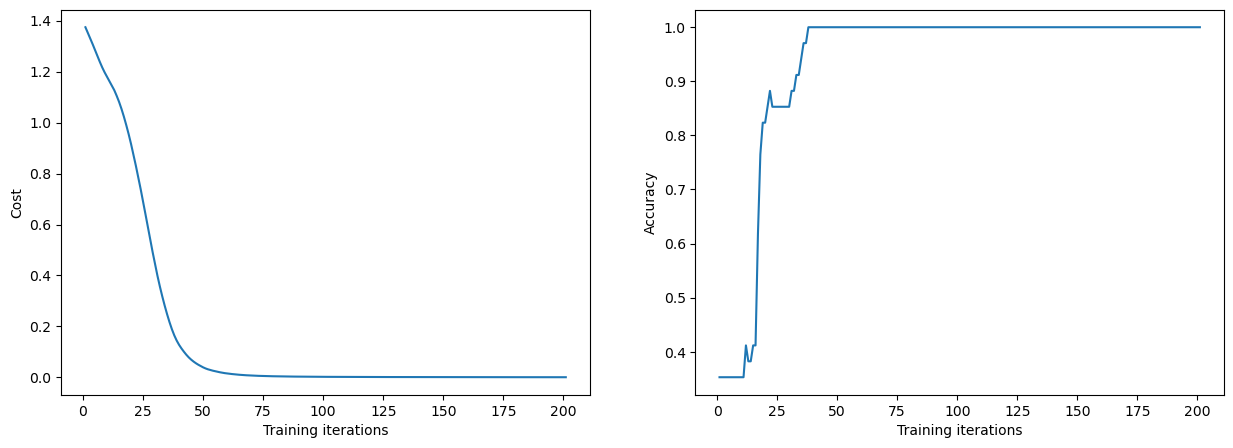

In [13]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(np.arange(1, len(losses)+1), losses) 
plt.xlabel('Training iterations')
plt.ylabel('Cost')

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(accuracies)+1), accuracies) 
plt.xlabel('Training iterations')
plt.ylabel('Accuracy');

## Visualizing Node Embeddings

- Extract node embeddings from the trained model using the code provided earlier
- Apply t-SNE for dimensionality reduction and create a scatter plot to visualize the embeddings in a 2D space.

C:\Users\MohammadAli\AppData\Local\Temp\ipykernel_4724\3123502946.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)


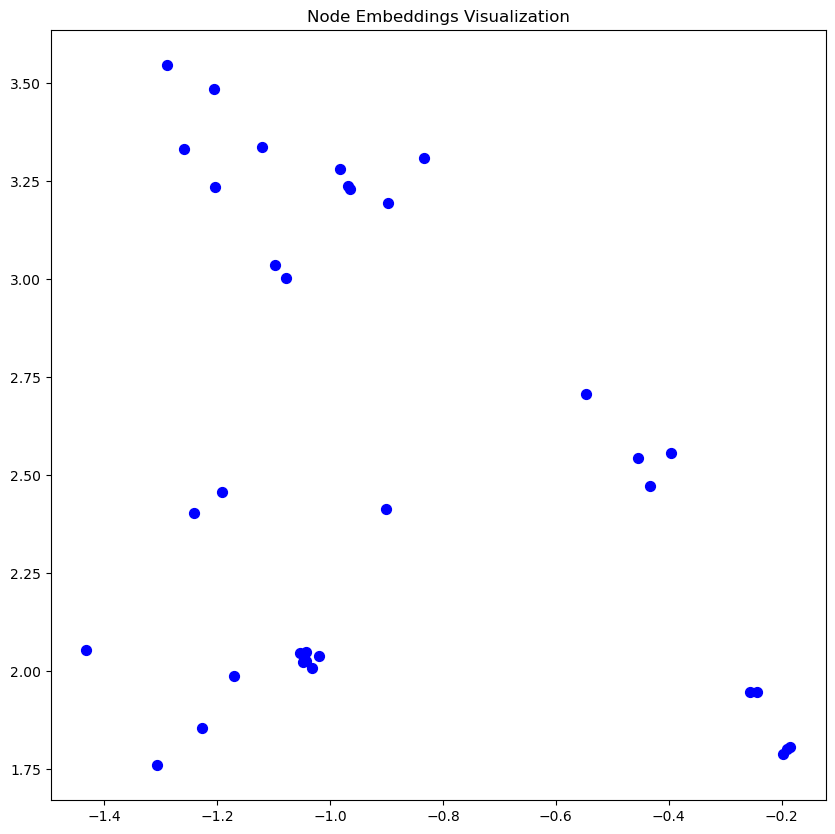

In [14]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)
plt.title("Node Embeddings Visualization")
plt.show()

## K-Means 

In [15]:
n_clusters = 4
new_labels = KMeans(n_clusters).fit_predict(embeddings)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [16]:
from sklearn.metrics import normalized_mutual_info_score

In [17]:
nmi_score = normalized_mutual_info_score(labels,new_labels)
print(f"NMI Score : {nmi_score}")

NMI Score : 0.9309605570261417


# Model Architecture (20 Layer)
- Define the GCN model architecture using PyTorch.
- The model consists of :
  - 20 GCN convolutional layers
  - a linear classifier.

In [18]:
gcn_layer = 20

In [19]:
model = GCN(gcn_layer)
print(model)

GCN(
  (gcn_layers): ModuleList(
    (0): GCNConv(34, 10)
    (1-19): 19 x GCNConv(10, 10)
  )
  (out): Linear(in_features=10, out_features=4, bias=True)
)


In [20]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.02)


In [21]:

# Calculate accuracy
def accuracy(pred_y, y):
    return (pred_y == y).sum() / len(y)

# Data for animations
embeddings = []
losses = []
accuracies = []
outputs = []

# Training loop
for epoch in range(201):
    # Clear gradients
    optimizer.zero_grad()

    # Forward pass
    h, z = model(data.x, data.edge_index)

    # Calculate loss function
    loss = criterion(z, data.y)

    # Calculate accuracy
    acc = accuracy(z.argmax(dim=1), data.y)

    # Compute gradients
    loss.backward()

    # Tune parameters
    optimizer.step()

    # Store data for animations
    embeddings.append(h)
    losses.append(float(loss))
    accuracies.append(float(acc))
    outputs.append(z.argmax(dim=1))

    # Print metrics every 10 epochs
    if epoch % 10 == 0:
        print(f'Epoch {epoch:>3} | Loss: {loss:.2f} | Acc: {acc*100:.2f}%')

Epoch   0 | Loss: 1.31 | Acc: 38.24%
Epoch  10 | Loss: 1.27 | Acc: 38.24%
Epoch  20 | Loss: 1.27 | Acc: 38.24%
Epoch  30 | Loss: 1.27 | Acc: 38.24%
Epoch  40 | Loss: 1.27 | Acc: 38.24%
Epoch  50 | Loss: 1.26 | Acc: 38.24%
Epoch  60 | Loss: 1.25 | Acc: 38.24%
Epoch  70 | Loss: 1.24 | Acc: 41.18%
Epoch  80 | Loss: 1.21 | Acc: 38.24%
Epoch  90 | Loss: 1.20 | Acc: 44.12%
Epoch 100 | Loss: 1.13 | Acc: 44.12%
Epoch 110 | Loss: 1.18 | Acc: 44.12%
Epoch 120 | Loss: 1.11 | Acc: 47.06%
Epoch 130 | Loss: 1.07 | Acc: 44.12%
Epoch 140 | Loss: 1.03 | Acc: 55.88%
Epoch 150 | Loss: 1.01 | Acc: 52.94%
Epoch 160 | Loss: 1.14 | Acc: 47.06%
Epoch 170 | Loss: 1.03 | Acc: 41.18%
Epoch 180 | Loss: 0.98 | Acc: 64.71%
Epoch 190 | Loss: 0.98 | Acc: 61.76%
Epoch 200 | Loss: 0.94 | Acc: 70.59%


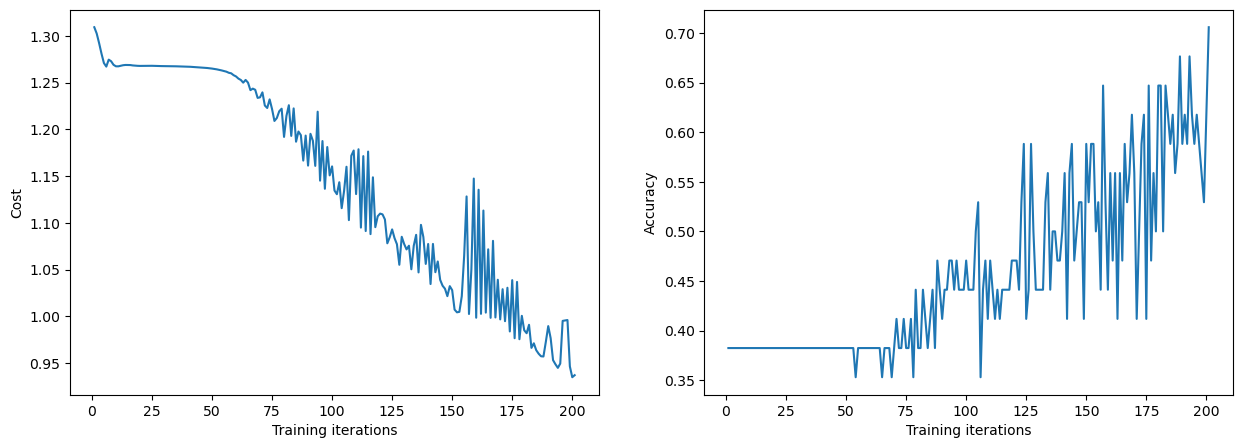

In [22]:
plt.figure(figsize=(15, 5))
plt.subplot(1,2,1)
plt.plot(np.arange(1, len(losses)+1), losses) 
plt.xlabel('Training iterations')
plt.ylabel('Cost')

plt.subplot(1,2,2)
plt.plot(np.arange(1, len(accuracies)+1), accuracies) 
plt.xlabel('Training iterations')
plt.ylabel('Accuracy');

## Visualizing Node Embeddings

- Extract node embeddings from the trained model using the code provided earlier
- Apply t-SNE for dimensionality reduction and create a scatter plot to visualize the embeddings in a 2D space.

C:\Users\MohammadAli\AppData\Local\Temp\ipykernel_4724\3123502946.py:12: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)


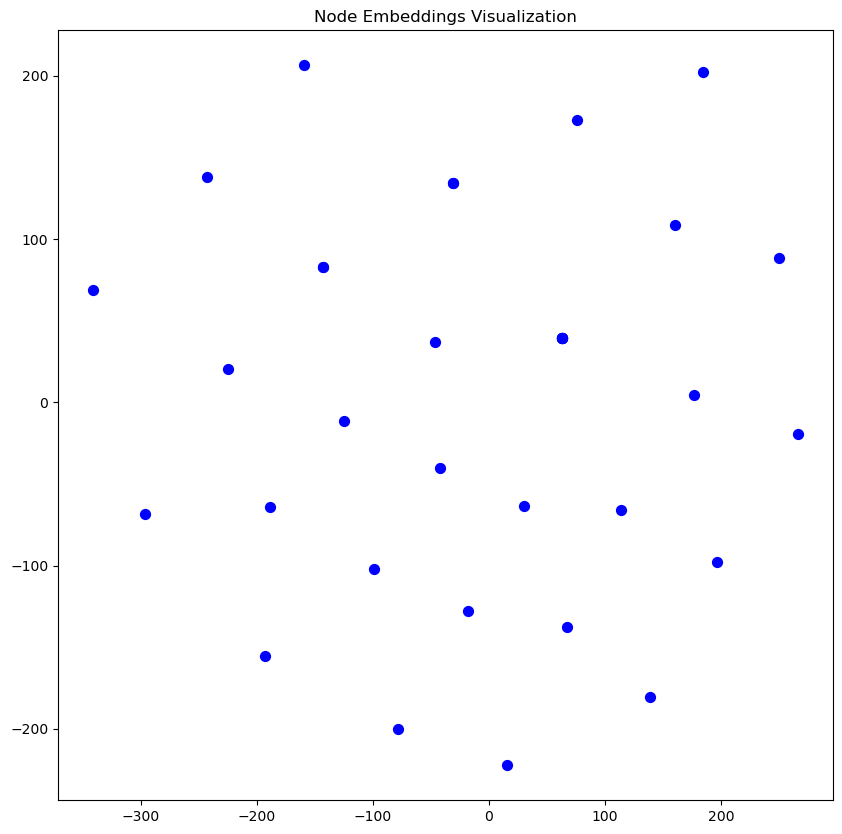

In [23]:
data = dataset[0]
out, embeddings = model(data.x, data.edge_index)

# Convert embeddings to a NumPy array
embeddings = embeddings.detach().numpy()

# Apply dimensionality reduction (e.g., t-SNE) for visualization
reduced_embeddings = TSNE(n_components=2).fit_transform(embeddings)

# Create a scatter plot to visualize the embeddings
plt.figure(figsize=(10, 10))
plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c='b', cmap='viridis', s=50)
plt.title("Node Embeddings Visualization")
plt.show()

## K-Means 

In [24]:
n_clusters = 4
new_labels = KMeans(n_clusters).fit_predict(embeddings)

c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\ProgramData\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1436: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [25]:
from sklearn.metrics import normalized_mutual_info_score

In [26]:
nmi_score = normalized_mutual_info_score(labels,new_labels)
print(f"NMI Score : {nmi_score}")

NMI Score : 0.3230399982314391


        The more the number of GCN layers, the over fitting it becomes.